In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyabc.visualization import plot_kde_2d, plot_data_callback


import pandas as pd

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)

import plotly.graph_objects as go

import TumorPatientData as TMD

import os
import tempfile

import numpy as np
import scipy as sp

In [85]:
MTD2Sphere = False
data = TMD.load_data(MTD2Sphere)

In [86]:
data_fig = TMD.make_plot(data, MTD2Sphere)
data_fig.show()

In [87]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "tumor.db"))

In [88]:
data[1]

,0,1,2,3,4,5,6,7,8,9,10,11
0,-44.082840,47.865894,-54.437870,41.468932,-4.142012,48.509995,-26.331361,40.148584,-98.520710,54.926006,-36.094675,42.401152
1,-31.952663,54.658126,-50.887574,45.076375,2.366864,44.660865,-1.183432,58.558451,-89.940828,57.507173,-30.177515,50.828045
2,-26.035503,55.640351,-50.000000,47.889705,6.804734,37.600752,5.917160,53.298489,-76.923077,59.869275,-25.147929,56.039194
3,-18.934911,60.843166,-13.609467,70.882097,10.355030,35.171979,10.650888,51.267368,-69.822485,64.066053,-18.639053,60.640768
4,-11.538462,63.227888,-3.550296,79.292322,14.201183,32.339600,17.455621,49.227912,-61.834320,65.442358,-10.946746,63.225507
5,-1.183432,68.820021,0.000000,81.290108,17.751479,33.733764,22.189349,52.428179,-44.082840,72.614385,-4.142012,62.192087
6,2.366864,63.775553,2.958580,88.722870,21.301775,30.097746,28.106509,49.587466,-31.065089,73.970450,13.017751,53.068708
7,8.284024,58.721560,4.437870,90.326575,26.035503,30.883526,35.798817,48.952889,-20.414201,77.348112,28.698225,49.182670
8,16.863905,55.266510,9.467456,77.831486,30.769231,36.498280,NaN,NaN,-7.100592,77.898158,33.727811,48.760016
9,21.597633,53.637803,14.497041,74.793138,36.390533,44.725156,NaN,NaN,-2.366864,79.488767,NaN,NaN


In [89]:
PATIENT_N = 0
PATIENT = (PATIENT_N, PATIENT_N+1)
GROUP = 0
measurement_data = np.array(data[GROUP][PATIENT[1]][data[GROUP][PATIENT[1]].notnull()])
measurement_data = np.array([round(d, 3) for d in measurement_data])
measurement_data

array([34.509, 40.048, 43.456, 47.29 , 54.959, 56.663, 53.255, 46.225,
       38.344, 36.426, 34.935, 33.444, 36.213])

In [203]:
measurement_times = np.array(data[GROUP][PATIENT[0]][data[GROUP][PATIENT[0]].notnull()])
measurement_times = np.array([round(t, 3) for t in measurement_times])
t_cure = measurement_times[0]
print(t_cure)
transform = lambda t: t - t_cure
# measurement_times = transform(measurement_times)

# measurement_times = np.arange(len(measurement_data))

measurement_times

-84.159


array([-84.159, -43.493, -31.607, -24.099, -12.212,  -4.705,   3.741,
         7.808,  21.572,  33.458,  39.715,  46.597,  55.981])

# Model
<img src="ODE_cycle.jpg" width="600">

## Czynniki
**P** - proliferative tissue, tumor tissue <br>
rozrastająca się tkanka rakowa

**Q** - non-proliferative tissue <br>
tkanka rakowa wyciszona

**QP** - DNA-damaged Q tissue by the drug impact <br>
tkanka rakowa wyciszona z uszkodzonym DNA

**C** - drug concentration <br>
obecna ilość leku w organiźmie (max 1)


## Parametry
**KDE** - constant rate of the decay of the drug concentration <br>
tempo zanikania wpływu leku

**lambda_P** - growth rate of P

**gamma_P** - damages in P tissue caused by the drug

**gamma_Q** - damages in Q tissue caused by the drug <br>
autorzy zakładają: gamma_P = gamma_Q

**k_QP_P** - constant rate of transfer from QP to P tissue 

**delta_QP** - constant rate of elimination of QP tissue

**k_P_Q** - constant rate of transfer from P to Q tissue

**K** - maximal tumor size

Initial conditions for C, P, Q, Q<sub>P</sub>

In [133]:
P_SUM_0 = measurement_data[0]
C_0 = 0
QP_0 = 0
P_0 = P_SUM_0 / 5
Q_0 = P_SUM_0 - P_0 - QP_0

init = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])

In [211]:
def f(t, y, KDE, lambda_P, gamma_P, gamma_Q, k_QP_P, delta_QP, k_P_Q, K):
    P_sum, C, P, Q, QP = y
#     P_sum = P + Q + QP

    t = round(t, 6)
    t_r = t + t_cure
    
    t_r = round(t_r, 6)
    
    if t < 0:
        dC = 0
    elif t >= 0 and C == 0:
        dC = 1
    else:
        dC = -KDE*C

#     if t_r < 0:
#         dC = 0
#     else:
#         if C != 0:
#             dC = -KDE * C
#         else: 
#             dC = 1

    
#     dC = -KDE * C
    dP = lambda_P * P * (1 - P_sum/K) + k_QP_P * QP - k_P_Q * P - gamma_P * C * KDE * P
    dQ = k_P_Q * P - gamma_Q * C * KDE * Q
    dQP = gamma_Q * C * KDE * Q - k_QP_P * QP - delta_QP * QP

    dP_sum = dP+ dQ + dQP
    
    print("t: " + str(t) + " t_r: " + str(t_r) + " C: " + str(C) + " dC: " + str(dC) + "\n" )
    
    return dP_sum, dC, dP, dQ, dQP

def model(pars):
    sol = sp.integrate.solve_ivp(fun=f, t_span=(measurement_times[0], measurement_times[-1]), t_eval=measurement_times,
                                y0=init, args=(
                                    pars["KDE"], pars["lambda_P"], pars["gamma_P"], pars["gamma_Q"],
                                    pars["kQP_P"], pars["delta_QP"], pars["k_PQ"], pars["K"]))
    
# #     sol = sp.integrate.odeint(f, init, measurement_times, args=(
#          pars["KDE"], pars["lambda_P"], pars["gamma_P"], pars["gamma_Q"],
#          pars["kQP_P"], pars["delta_QP"], pars["k_PQ"], pars["K"]))
    return {"P_sum": sol.y[0, :], "C": sol.y[1, :]}

## Wartości parametrów z artykułu dla PCV

In [214]:
KDE_art= 0.1
lambda_P_art = 0.121
gamma_P_art = 0.3
gamma_Q_art = gamma_P_art
kQP_P_art = 0.05
delta_QP_art = 0.01
k_PQ_art = 0.1
K_art = 100

In [215]:
article_growth = model({"KDE": KDE_art, "lambda_P": lambda_P_art, "gamma_P": gamma_P_art, 
                        "gamma_Q": gamma_Q_art, "kQP_P": kQP_P_art, "delta_QP": delta_QP_art,
                        "k_PQ": k_PQ_art,"K": K_art}
                       )
article_growth

t: -84.159 t_r: -168.318 C: 0.0 dC: 0

t: -83.679902 t_r: -167.838902 C: 0.0 dC: 0

t: -84.113364 t_r: -168.272364 C: 0.0 dC: 0

t: -84.090546 t_r: -168.249546 C: 0.0 dC: 0

t: -83.976457 t_r: -168.135457 C: 0.0 dC: 0

t: -83.956174 t_r: -168.115174 C: 0.0 dC: 0

t: -83.930821 t_r: -168.089821 C: 0.0 dC: 0

t: -83.930821 t_r: -168.089821 C: 0.0 dC: 0

t: -83.474463 t_r: -167.633463 C: 0.0 dC: 0

t: -83.246284 t_r: -167.405284 C: 0.0 dC: 0

t: -82.105388 t_r: -166.264388 C: 0.0 dC: 0

t: -81.902562 t_r: -166.061562 C: 0.0 dC: 0

t: -81.64903 t_r: -165.80803 C: 0.0 dC: 0

t: -81.64903 t_r: -165.80803 C: 0.0 dC: 0

t: -77.085448 t_r: -161.244448 C: 0.0 dC: 0

t: -74.803657 t_r: -158.962657 C: 0.0 dC: 0

t: -63.394703 t_r: -147.553703 C: 0.0 dC: 0

t: -61.366444 t_r: -145.525444 C: 0.0 dC: 0

t: -58.831121 t_r: -142.990121 C: 0.0 dC: 0

t: -58.831121 t_r: -142.990121 C: 0.0 dC: 0

t: -52.230889 t_r: -136.389889 C: 0.0 dC: 0

t: -48.930773 t_r: -133.089773 C: 0.0 dC: 0

t: -32.430193 t_r: -

{'P_sum': array([34.509     , 46.74153463, 47.99117628, 48.53138375, 49.12479586,
        49.37972674, 49.58952704, 49.6684251 , 49.85799433, 49.95517965,
        49.99118194, 50.02164864, 50.05172984]),
 'C': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.69010061e-13, 5.41142073e-13,
        1.98059291e-14, 3.49932592e-13, 1.46335493e-13, 6.79115536e-14,
        8.29275170e-14])}

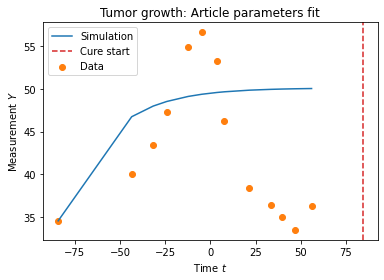

In [216]:
plt.plot(measurement_times, article_growth['P_sum'], color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.axvline(x=abs(t_cure), color='C3', ls='--', label='Cure start')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Tumor growth: Article parameters fit')
plt.legend()
plt.show()

In [217]:
def distance(simulation, data):
    # L1
#     dist =  np.absolute(data['P_sum'] - simulation["P_sum"]).sum()
    # L2
    diff = simulation['P_sum'] - data['P_sum']
    dist = np.sqrt(np.sum(diff**2))
    return dist


In [23]:
parameter_prior = Distribution(KDE=RV("uniform", 0, 1), lambda_P=RV("uniform", 0, 1),
                               gamma_P=RV("uniform", 0, 1), gamma_Q=RV("uniform", 0, 1),
                               kQP_P=RV("uniform", 0, 1), delta_QP=RV("uniform", 0, 1),
                               k_PQ=RV("uniform", 0,1), K=RV("uniform", 0, 1))
parameter_prior.get_parameter_names()

['K', 'KDE', 'delta_QP', 'gamma_P', 'gamma_Q', 'kQP_P', 'k_PQ', 'lambda_P']

In [35]:
abc = ABCSMC(models=model,
             parameter_priors=parameter_prior,
             distance_function=distance,
             population_size=50,
             transitions=LocalTransition(k_fraction=.3),
             eps=MedianEpsilon(200, median_multiplier=0.7))

INFO:Sampler:Parallelizing the sampling on 4 cores.


In [36]:
abc.new(db_path, {"P_sum": measurement_data});

INFO:History:Start <ABCSMC(id=90, start_time=2020-11-13 18:04:12.684120, end_time=None)>


In [37]:
h = abc.run(minimum_epsilon=45, max_nr_populations=2)

INFO:ABC:t: 0, eps: 200.
INFO:ABC:Acceptance rate: 50 / 53 = 9.4340e-01, ESS=5.0000e+01.
INFO:ABC:t: 1, eps: 42.64547044479132.


KeyboardInterrupt: 

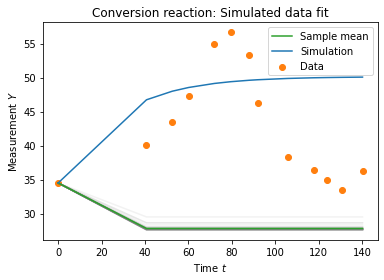

In [34]:
_, ax = plt.subplots()

def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['P_sum'], color='grey', alpha=0.1)
    
def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['P_sum'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')
    
ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

plt.plot(measurement_times, article_growth, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data,
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: Simulated data fit')
plt.legend()
plt.show()

In [52]:
def f2(y, t):
    return 2

In [155]:
sol1 = sp.integrate.solve_ivp(f2, [0,1,2,3,4,5,6], [0])
sol1.y

array([[0.000e+00, 2.000e-04, 2.200e-03, 2.220e-02, 2.222e-01, 2.000e+00]])